In [84]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec

#=========================
# Load Driver
driver = webdriver.Chrome()
url = 'http://www.forestdss.org.uk/geoforestdss'
driver.get(url)

#=========================
# Locate search bar and enter Grid Ref.
search_bar = driver.find_element(By.ID, 'gridref')
search_bar.clear()
search_bar.send_keys("NT090950")
go = driver.find_element(By.XPATH, "//input[@value='Go']")
go.click()

#=========================
# Download CSV from results
download = WebDriverWait(driver, 10).until(
    ec.presence_of_element_located((By.XPATH, "//a[contains(@href, 'EscModelServlet')]"))
)
download.click()


In [263]:
def generate_grid_ref(grid_squares):

    import random

    references = set()
    
    for grid_square in grid_squares:

        easting = random.randint(0,99)
        northing = random.randint(0,99)
        easting_str = f'{easting:03d}'
        northing_str = f'{northing:03d}'
        grid_ref = f"{grid_square}{easting_str}{northing_str}"

        references.add(grid_ref)

    return list(references)

In [95]:
grid_squares = ['SP', 'SO', 'SK']
generate_grid_ref(grid_squares)

['SP070030', 'SO049075', 'SK004068']

In [114]:
from openpyxl import Workbook
import pandas as pd
import csv

wb = Workbook()
ws = wb.active
with open('P:\ESC_NT090950.csv', 'r') as f:
    for row in csv.reader(f):
        ws.append(row)
wb.save('P:\ESC_NT090950_TEST.xlsx')

at = int(pd.read_excel('P:\ESC_NT090950_TEST.xlsx').iloc[9][1])
print(f'Accumulated Temperature: {at}')

Accumulated Temperature: 1096


In [264]:
def initiate_driver():

    from selenium import webdriver

    #=========================
    # Load Driver
    driver = webdriver.Chrome()
    
    return driver

def scrape_esc(driver, input_file_path, url = 'http://www.forestdss.org.uk/geoforestdss'):

    from selenium.webdriver.common.by import By
    from selenium.webdriver.common.keys import Keys
    from selenium.webdriver.support.select import Select
    
    driver.get(url)

    #=========================
    # Change drop down option to 'Download ESC Site Data'
    select = Select(driver.find_element(By.ID, 'select_tool'))
    select.select_by_visible_text('Download ESC Site Data')

    #=========================
    # Upload file template and download results
    form = driver.find_element(By.ID, 'esc-data')
    file_input = form.find_element(By.ID, 'esc-file')
    file_input.send_keys(input_file_path)
    form.submit()

    #=========================
    # Read in results
    # df = pd.read_csv('/Users/dougaltoms/Downloads/esc_data.csv')
    return #df

In [265]:
def convert_eastings_northing_to_lat_lon(df):

    import requests
    import pandas as pd
    import json

    requests.packages.urllib3.disable_warnings()

    lat = []
    lon = []

    for index, row in df.iterrows():
        easting = index
        northing = row['y']

        url = fr'https://webapps.bgs.ac.uk/data/webservices/CoordConvert_LL_BNG.cfc?method=BNGtoLatLng&easting={easting}&northing={northing}'
        r = requests.get(url, verify=False)
        j = json.loads(r.content.decode('utf-8'))

        lon.append(j['LONGITUDE'])
        lat.append(j['LATITUDE'])

    df['latitude'] = lat
    df['longitude'] = lon

    return df

In [266]:
def generate_sampling_locs(file_version):

    import random
    import pandas as pd

    df = pd.DataFrame({'x':[], 'y':[], 'species':[]})

    #========================
    # UK bbox in lat/lon then easting/northing
    bbox = ((9.184570,49.837982),(2.329102,59.489726)) 
    bbox = ((116315, 17883),(645170, 1075060))

    #========================
    # UK Native tree species to search for
    trees = ['POK' # Pedunculate Oak
    , 'ROK' # Red Oak
    , 'SOK' # Sessile Oak
    , 'SC' # Sweet Chestnut
    , 'SLI' # Small leaved Lime
    , 'CAR' # Common Alder
    , 'AH' # Ash
    , 'ASP' # Aspen
    , 'PBI' # Downy Birch
    , 'SBI' # Silver Birch
    , 'WCH' # Wild Cherry
    , 'WEM' # Wych Elm
    , 'HBM' # Hornbeam
    , 'SP' # Scotts Pine
    , 'BPO' # Black Poplar
    , 'ROW' # Rowan
    ]

    x = []
    y = []
    species = []

    #========================
    # Generate random east/north and add to DF with each tree species
    for i in range(1,7):
        easting = random.randint(bbox[0][0], bbox[1][0])
        northing = random.randint(bbox[0][1], bbox[1][1])
        for tree in trees:
            x.append(easting)
            y.append(northing)
            species.append(tree)
            # species.append(random.choice(trees))

    df['x'] = x
    df['y'] = y
    df['species'] = species

    #====================
    # Set index and save as csv
    df = df.set_index('x')
    if file_version != 1:
        path = f'/Users/dougaltoms/Downloads/esc_sample{file_version-1}.csv'
    else:
        path = f'/Users/dougaltoms/Downloads/esc_sample.csv'
        
    df.to_csv(path)

    return path

In [267]:
def clean_esc_data(df):
    #============================
    # Read enriched CSV and remove non-land coords (i.e. where elevation =-9999)
    # df_enriched = pd.read_csv('/Users/dougaltoms/Downloads/esc_data.csv')
    df = df[df['elevation']!= -9999]

    df = df.rename(columns={'at':'accumulated_temperature'
        , 'ct':'continentality'
        , 'md':'moisture_deficit'
        , 'smr':'soil_moisture_regime'
        , 'snr':'soil_nutrient_regime'})
        
    df = convert_eastings_northing_to_lat_lon(df)

    return df
    # '''Write to DuckDB^?'''

In [393]:
df3[df3['latitude'].between(53,55)]

,Unnamed: 0.1,x,y,accumulated_temperature,continentality,dams,moisture_deficit,soil_moisture_regime,soil_nutrient_regime,elevation,...,cyc,limitingfact,ecosuit,nvc1,nvc2,nvc3,latitude,longitude,Unnamed: 0,geometry
0,0,373922.0,351024.0,1665,8,12,163,4.0,5.0,76,...,8.0,DAMS,0.97,W6,W9,W7,53.055827,-2.390526,NaN,POINT (-2.3905262024079 53.055827272514)
1,1,373922.0,351024.0,1665,8,12,163,4.0,5.0,76,...,7.0,SNR,0.76,W6,W9,W7,53.055827,-2.390526,NaN,POINT (-2.3905262024079 53.055827272514)
2,2,373922.0,351024.0,1665,8,12,163,4.0,5.0,76,...,8.0,SNR,0.64,W6,W9,W7,53.055827,-2.390526,NaN,POINT (-2.3905262024079 53.055827272514)
3,3,373922.0,351024.0,1665,8,12,163,4.0,5.0,76,...,12.0,SNR,0.55,W6,W9,W7,53.055827,-2.390526,NaN,POINT (-2.3905262024079 53.055827272514)
4,4,373922.0,351024.0,1665,8,12,163,4.0,5.0,76,...,9.0,DAMS,0.94,W6,W9,W7,53.055827,-2.390526,NaN,POINT (-2.3905262024079 53.055827272514)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17403,13899,347600.0,446796.0,1672,7,12,167,3.0,3.0,18,...,8.0,SNR,0.67,W4,W7,W1,53.914647,-2.799235,12859.0,POINT (-2.79923462092075 53.9146472060804)
17404,13900,347600.0,446796.0,1672,7,12,167,3.0,3.0,18,...,9.0,SMR,0.75,W4,W7,W1,53.914647,-2.799235,12860.0,POINT (-2.79923462092075 53.9146472060804)
17405,13901,347600.0,446796.0,1672,7,12,167,3.0,3.0,18,...,14.0,SMR,0.63,W4,W7,W1,53.914647,-2.799235,12861.0,POINT (-2.79923462092075 53.9146472060804)
17406,13902,347600.0,446796.0,1672,7,12,167,3.0,3.0,18,...,16.0,SNR,0.60,W4,W7,W1,53.914647,-2.799235,12862.0,POINT (-2.79923462092075 53.9146472060804)


In [362]:
import pandas as pd
import time

#======================
# Initiate master DF
cols = ['x', 'y', 'accumulated_temperature', 'continentality', 'dams',
       'moisture_deficit', 'soil_moisture_regime', 'soil_nutrient_regime',
       'elevation', 'species', 'yc', 'cyc', 'limitingfact', 'ecosuit', 'nvc1',
       'nvc2', 'nvc3', 'latitude', 'longitude']
df_final = pd.DataFrame(columns=cols)
df_final = df_final.set_index('x')

# Create selenium driver
driver = initiate_driver()

# Create sampling file, send to ESC, clean, add to master DF
for file_version in range(1,500):

    print(f'Generating Sampling Doc v{file_version}')
    locs_file_path = generate_sampling_locs(file_version)
    print('Scraping data from ESC')
    scrape_esc(driver, locs_file_path)
    time.sleep(1)
    if file_version == 1:
        df = pd.read_csv('/Users/dougaltoms/Downloads/esc_data.csv', index_col='x')
    else:
        df = pd.read_csv(f'/Users/dougaltoms/Downloads/esc_data ({file_version-1}).csv', index_col='x')
    df = clean_esc_data(df)
    df_final = pd.concat([df_final, df])

Generating Sampling Doc v1
Scraping data from ESC
Generating Sampling Doc v2
Scraping data from ESC
Generating Sampling Doc v3
Scraping data from ESC
Generating Sampling Doc v4
Scraping data from ESC
Generating Sampling Doc v5
Scraping data from ESC
Generating Sampling Doc v6
Scraping data from ESC
Generating Sampling Doc v7
Scraping data from ESC
Generating Sampling Doc v8
Scraping data from ESC
Generating Sampling Doc v9
Scraping data from ESC
Generating Sampling Doc v10
Scraping data from ESC
Generating Sampling Doc v11
Scraping data from ESC
Generating Sampling Doc v12
Scraping data from ESC
Generating Sampling Doc v13
Scraping data from ESC
Generating Sampling Doc v14
Scraping data from ESC
Generating Sampling Doc v15
Scraping data from ESC
Generating Sampling Doc v16
Scraping data from ESC
Generating Sampling Doc v17
Scraping data from ESC
Generating Sampling Doc v18
Scraping data from ESC
Generating Sampling Doc v19
Scraping data from ESC
Generating Sampling Doc v20
Scraping dat

WebDriverException: Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=128.0.6613.114)
Stacktrace:
0   chromedriver                        0x00000001075ff248 chromedriver + 5096008
1   chromedriver                        0x00000001075f6a7a chromedriver + 5061242
2   chromedriver                        0x0000000107181fd0 chromedriver + 389072
3   chromedriver                        0x0000000107169466 chromedriver + 287846
4   chromedriver                        0x0000000107169363 chromedriver + 287587
5   chromedriver                        0x0000000107184302 chromedriver + 398082
6   chromedriver                        0x000000010720fc73 chromedriver + 969843
7   chromedriver                        0x00000001071f2c93 chromedriver + 851091
8   chromedriver                        0x00000001071c1c79 chromedriver + 650361
9   chromedriver                        0x00000001071c249e chromedriver + 652446
10  chromedriver                        0x00000001075c1fc0 chromedriver + 4845504
11  chromedriver                        0x00000001075c6ed8 chromedriver + 4865752
12  chromedriver                        0x00000001075c75a5 chromedriver + 4867493
13  chromedriver                        0x00000001075a4bf9 chromedriver + 4725753
14  chromedriver                        0x00000001075c7899 chromedriver + 4868249
15  chromedriver                        0x0000000107596b14 chromedriver + 4668180
16  chromedriver                        0x00000001075e6d78 chromedriver + 4996472
17  chromedriver                        0x00000001075e6f77 chromedriver + 4996983
18  chromedriver                        0x00000001075f667e chromedriver + 5060222
19  libsystem_pthread.dylib             0x00007ff811bc34e1 _pthread_start + 125
20  libsystem_pthread.dylib             0x00007ff811bbef6b thread_start + 15


In [363]:
import pandas as pd
df_final.to_csv("/Users/dougaltoms/Documents/Rewilder/esc_scraped.csv")
df1 = pd.read_csv('/Users/dougaltoms/Documents/Rewilder/esc_scraped.csv')
df2 = pd.read_csv('/Users/dougaltoms/Documents/Rewilder/ecological_site_classification.csv')

df3 = pd.concat([df1, df2])
df3.to_csv('/Users/dougaltoms/Documents/Rewilder/ecological_site_classification2.csv')

In [358]:
df3.to_csv('/Users/dougaltoms/Documents/Rewilder/ecological_site_classification2.csv')

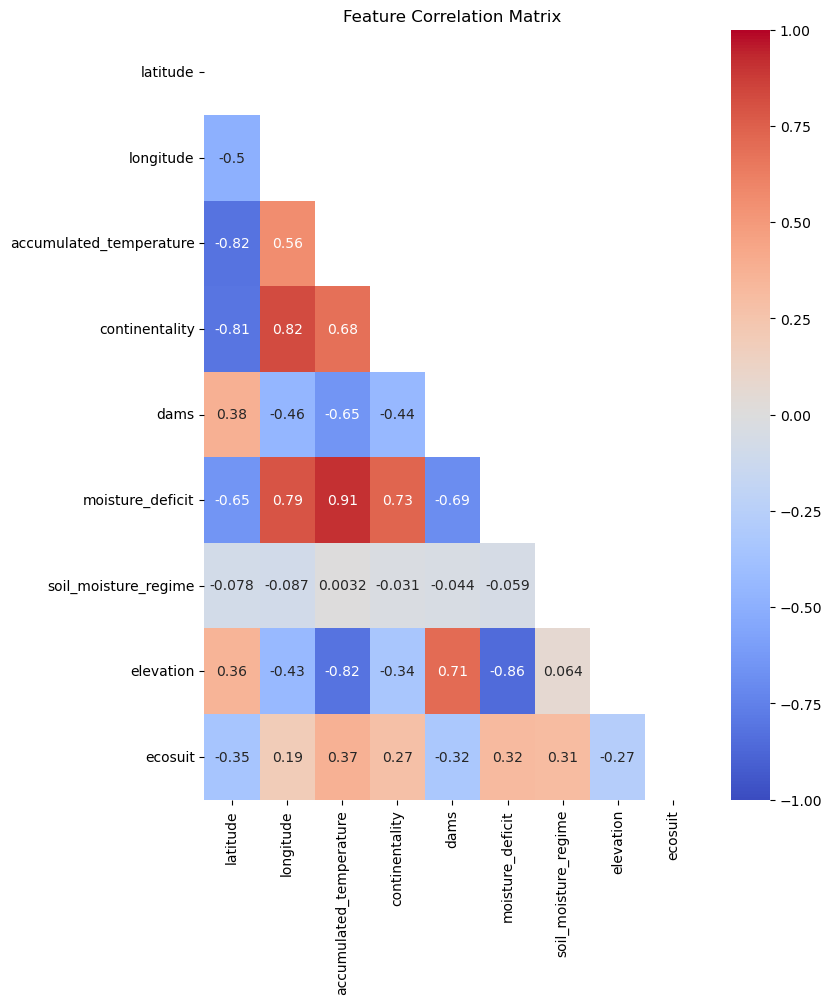

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#============================
# Remove unwanted cols, encode species col
df_correlation = df_final[['latitude'
                        , 'longitude'
                        , 'accumulated_temperature'
                        , 'continentality'
                        , 'dams'
                        , 'moisture_deficit'
                        , 'soil_moisture_regime'
                        , 'elevation'
                        , 'ecosuit']]

correlation_matrix = df_correlation.corr(method='pearson', numeric_only = False)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.title('Feature Correlation Matrix')
plt.show()

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

eng_ag = gpd.read_file('/Users/dougaltoms/Documents/Rewilder/shapefiles/England/Agricultural_Land_Classification_Provisional_England.shp')
scot_ag = gpd.read_file('/Users/dougaltoms/Documents/Rewilder/shapefiles/Scotland/LCA_250K.shp')
wales_ag = gpd.read_file('/Users/dougaltoms/Documents/Rewilder/shapefiles/Wales/wg_predictive_alc2.shp')

In [6]:
#==============================
# Extract digits from codes to make a uniform grading between England and Scotland
eng_ag['NUMERIC_GRADE'] = eng_ag['alc_grade'].str.extract('(\d+)', expand=False).astype(float)
scot_ag['NUMERIC_GRADE'] = scot_ag['LCCODE'].astype(str).str.extract('(\d+)', expand=False).astype(float)
wales_ag['NUMERIC_GRADE'] = wales_ag['predictive'].astype(str).str.extract('(\d+)', expand=False).astype(float)

#==============================
# Filter each DF to remove huge ranges/NaNs <-- need to read up on what these codes actually mean
eng_ag = eng_ag[eng_ag['NUMERIC_GRADE'] > 0]
scot_ag = scot_ag[scot_ag['NUMERIC_GRADE'] < 9]

#==============================
# Convert to same coords system, concat and plot based on new Land Use codes
scot_ag = scot_ag.to_crs('EPSG:4326')
eng_ag = eng_ag.to_crs('EPSG:4326')
wales_ag = wales_ag.to_crs('EPSG:4326')
uk_ag = gpd.pd.concat([eng_ag, scot_ag, wales_ag])
# plot = eng_scot_ag.plot(figsize=(8,10), column='NUMERIC_GRADE')
# plot.set_axis_off()

In [13]:
# Save as geojson
import geopandas as gpd
import json

uk_ag3 = (uk_ag[uk_ag['NUMERIC_GRADE']<3])
geojson = uk_ag3.to_json()

# # Save as a GeoJSON file if needed
# with open("uk_agri_capability.geojson", "w") as f:
#     json.dump(geojson, f)

In [ ]:
import plotly.express as px
import geopandas as gpd

fig = px.choropleth(
    uk_ag,
    geojson=json.loads(geojson),
    locations=uk_ag.index,  # Use index to link rows with polygons
    featureidkey="properties.index",  # The key to match GeoJSON feature IDs
    color="NUMERIC_GRADE",  # Column for color coding
    color_continuous_scale="Viridis",  # Color scale for NUMERIC_GRADE
    title="UK Farmland Quality",
)

# Update layout for better visualization
fig.update_geos(fitbounds="locations", visible=False)  # Fit the map to the polygons and remove the coastlines/borders

# Show the plot
fig.show()

In [394]:
import pickle

with open('uk_ag.pickle', 'wb') as file:
    pickle.dump(uk_ag, file)

In [387]:
from shapely.geometry import Point
import pandas as pd

df3 = pd.read_csv('/Users/dougaltoms/Documents/Rewilder/ecological_site_classification.csv')

df3['geometry'] = df3.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf3 = gpd.GeoDataFrame(df3, geometry='geometry', crs="EPSG:4326")

if gdf3.crs != uk_ag.crs:
    gdf3 = gdf3.to_crs(uk_ag.crs)

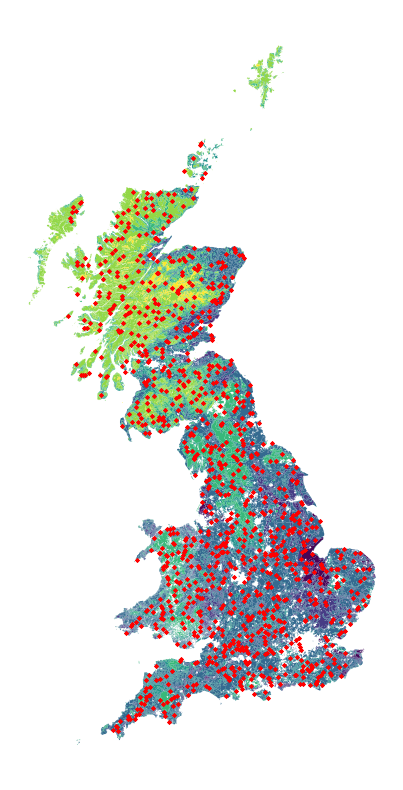

In [366]:
fig, ax = plt.subplots(figsize=(8, 10))
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)
uk_ag.plot(ax=ax, column='NUMERIC_GRADE', legend=False, cmap='viridis', alpha=0.98)
gdf3.plot(ax=ax, marker='o', color='red', markersize=2, label='Sampling Points').set_axis_off()
plt.show()

## duckdb
---

In [367]:
import duckdb
import pandas as pd

df = pd.read_csv('/Users/dougaltoms/Documents/Rewilder/ecological_site_classification.csv')

conn = duckdb.connect('rewilder.db')

conn.execute('''CREATE OR REPLACE TABLE ecological_site_classification
                     (x float, y float, accumulated_temperature int
                     , continentality int, dams int, moisture_deficit int
                     , soil_moisture_regime int, soil_nutrient_regime int
                     , elevation int, species varchar(3), yc int, cyc int
                     , limitingfact varchar(4), ecosuit float
                     , nvc1 varchar(3), nvc2 varchar(3), nvc3 varchar(3)
                     , latitude float, longitude float)''')

conn.execute('''INSERT INTO ecological_site_classification
                     SELECT x
                        , y
                        , accumulated_temperature
                        , continentality
                        , dams
                        , moisture_deficit
                        , soil_moisture_regime
                        , soil_nutrient_regime
                        , elevation
                        , species
                        , yc
                        , cyc
                        , limitingfact
                        , ecosuit
                        , nvc1
                        , nvc2
                        , nvc3
                        , latitude
                        , longitude
                    FROM df''')


In [368]:
conn.sql('''WITH cte as (PIVOT ecological_site_classification
                        ON species
                        USING max(ecosuit))
            SELECT x, y, 
            FROM cte 
    ''')

┌─────────────┬──────────┐
│      x      │    y     │
│    float    │  float   │
├─────────────┼──────────┤
│    540718.0 │ 357167.0 │
│    540718.0 │ 357167.0 │
│    470531.0 │ 331925.0 │
│    470531.0 │ 331925.0 │
│    389656.0 │ 457578.0 │
│    334724.0 │ 826887.0 │
│    334724.0 │ 826887.0 │
│    292740.0 │ 843305.0 │
│    292740.0 │ 843305.0 │
│    308158.0 │ 653110.0 │
│        ·    │     ·    │
│        ·    │     ·    │
│        ·    │     ·    │
│    387512.0 │ 229978.0 │
│    410093.0 │ 588319.0 │
│    355924.0 │ 713094.0 │
│    317741.0 │ 190854.0 │
│    317741.0 │ 190854.0 │
│    565495.0 │ 173161.0 │
│    272587.0 │ 881024.0 │
│    272587.0 │ 881024.0 │
│    272587.0 │ 881024.0 │
│    277671.0 │ 963841.0 │
├─────────────┴──────────┤
│ ? rows       2 columns │
└────────────────────────┘

## ML model
---

In [369]:
df3 = df3.drop('Unnamed: 0', axis=1)
df3 = df3.drop('Unnamed: 0.1', axis=1)

### Multi-Target Regression
---

In [370]:
df_pivot = df3.pivot_table(index=['latitude', 'longitude', 'accumulated_temperature', 'soil_moisture_regime', 'soil_nutrient_regime'], columns='species', values='ecosuit')
df_pivot = df_pivot.reset_index()

In [371]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df_pivot[['latitude', 'longitude','accumulated_temperature', 'soil_moisture_regime', 'soil_nutrient_regime']]
y = df_pivot[['AH', 'ASP', 'BPO', 'CAR', 'HBM', 'PBI', 'POK', 'ROK', 'ROW', 'SBI', 'SC', 'SLI', 'SOK', 'SP', 'WCH', 'WEM']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred, multioutput='uniform_average')
mse = mean_squared_error(y_test, y_pred, multioutput='uniform_average')
r2 = r2_score(y_test, y_pred, multioutput='uniform_average')

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R^2): {r2}")

Mean Absolute Error (MAE): 0.021586697247706614
Mean Squared Error (MSE): 0.002550171605504588
R-squared (R^2): 0.9761845073226127


In [372]:
new_data = pd.DataFrame({
    'latitude': [56],
    'longitude': [2],
    'accumulated_temperature': [2100],
    'soil_moisture_regime': [4],
    'soil_nutrient_regime': [4]
})

predicted_scores = model.predict(new_data)
predicted_df = pd.DataFrame(predicted_scores, columns=['AH', 'ASP', 'BPO', 'CAR', 'HBM', 'PBI', 'POK', 'ROK', 'ROW', 'SBI', 'SC', 'SLI', 'SOK', 'SP', 'WCH', 'WEM'])

top_species = predicted_df.T.nlargest(3, 0).reset_index()
top_species.columns = ['Species', 'Ecosuit Score']

print(top_species)

  Species  Ecosuit Score
0     HBM         0.9257
1     ROK         0.8415
2      SP         0.8273


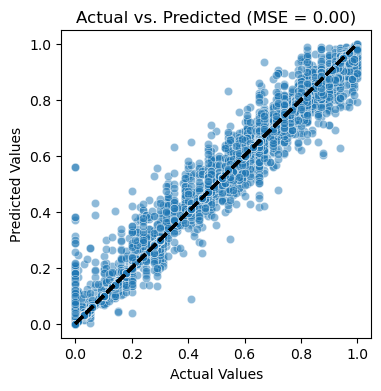

In [373]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)

# Plot
plt.figure(figsize=(4, 4))
plt.scatter(y, y_pred, alpha=0.5, edgecolors='w', linewidth=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title(f'Actual vs. Predicted (MSE = {mse:.2f})')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


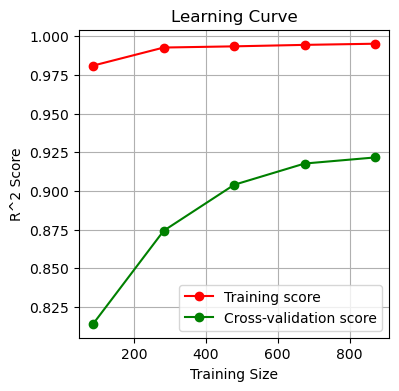

In [374]:
from sklearn.model_selection import learning_curve

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='r2', n_jobs=-1)

# Plot
plt.figure(figsize=(4, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('R^2 Score')
plt.legend(loc='best')
plt.grid()
plt.show()

#### Pickle ML model to be used in Streamlit app
---

In [361]:
import pickle

with open('model.pickle', 'wb') as file:
    pickle.dump(model, file)

### Random Forest Regressor
---

In [285]:
# Inlcude all features to start (minus labels)

# df_encoded = pd.get_dummies(df3, columns=['limitingfact'], drop_first=True)

X = df3[['accumulated_temperature', 'continentality', 'dams',
       'moisture_deficit', 'soil_moisture_regime', 'soil_nutrient_regime',
       'elevation','latitude', 'longitude']]
       
X = df3[['accumulated_temperature', 'soil_nutrient_regime', 'elevation', 'latitude', 'longitude']] # most relevant features from RFE

species = pd.get_dummies(df3['species'])
for column in species.columns:
    species[column] = species[column] * df3['ecosuit']

y = species

In [286]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [287]:
from sklearn.ensemble import RandomForestRegressor

# Initialize a Random Forest Regressor
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

# Extract feature importances
feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head()

,Feature,Importance
4,longitude,0.225258
3,latitude,0.205420
1,soil_nutrient_regime,0.202861
0,accumulated_temperature,0.184096
2,elevation,0.182365


In [284]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# Recursive Feature Elimination
rfe = RFE(estimator=model, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Pruned Features: ", selected_features)

Pruned Features:  Index(['accumulated_temperature', 'soil_nutrient_regime', 'elevation',
       'latitude', 'longitude'],
      dtype='object')


In [288]:
def predict_top_species(model, X_new, species_columns, top_n=3):
 # Predict ecosuit scores
 predictions = model.predict(X_new)
 
 # Convert predictions to a DataFrame
 preds_df = pd.DataFrame(predictions, columns=species_columns)
 
 # Get the top N species
 top_species = preds_df.T.nlargest(top_n, 0).reset_index()
 top_species.columns = ['Species', 'Ecosuit_Score']
 return top_species

In [290]:
# Example input for a new (x, y) coordinate 
new_location = pd.DataFrame({
 'accumulated_temperature':[1755],
 'soil_nutrient_regime':[5],
 'elevation':[74],
 'latitude':[52.304981],
 'longitude':[-2.6001923]
})
# Get the top 3 species for this location
top_3_species = predict_top_species(model, new_location, y.columns)
print(top_3_species)

  Species  Ecosuit_Score
0     WCH       0.085399
1     HBM       0.077886
2     SLI       0.075386


In [291]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R^2): {r2}')

Mean Absolute Error (MAE): 0.051765159336247264
Mean Squared Error (MSE): 0.019854697383011793
R-squared (R^2): -0.12800263954012464
